In [1]:
import pandas as pd
import numpy as np
import copy
import warnings

warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)

In [137]:
data = pd.read_parquet('../data/sas/mart/data_mart.parquet')

<h3>NA</h3>

In [138]:
data.isna().sum(axis=0).sum()

0

In [139]:
df = copy.deepcopy(data)

In [140]:
df.shape

(28834, 39)

<h3>Remove correlation</h3>

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.context('seaborn');

In [142]:
corr = df.corr(method='spearman')

In [143]:
# flag correlated items as True (except diagonal)
corr_mask = (abs(corr) > 0.85) * np.invert(np.eye(len(corr)).astype(bool))
# remove them
decorr_columns = corr[corr_mask].isna().all()
# get names
decorr_columns = decorr_columns[decorr_columns].index.values

In [144]:
decorr_columns = decorr_columns[(decorr_columns != 'none') * (decorr_columns != 'Unknown')]

In [25]:
df = df[decorr_columns]

In [27]:
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,avg_item_profit,related products,office goods,breastfeeding products,"textile, knitwear",footwear,toys,women things,goods for pets,cosmetics and hygiene,diapers,avg_delivered
avg_item_profit,1.00,-0.02,-0.04,-0.14,0.11,0.15,-0.05,-0.02,-0.11,-0.23,-0.28,0.02
related products,-0.02,1.00,0.03,-0.00,0.02,0.00,0.03,0.03,-0.00,0.01,-0.02,-0.01
office goods,-0.04,0.03,1.00,-0.00,-0.01,0.01,0.02,0.02,-0.00,0.02,-0.05,-0.01
breastfeeding products,-0.14,-0.00,-0.00,1.00,0.02,-0.05,-0.14,0.04,-0.01,0.22,0.05,-0.03
"textile, knitwear",0.11,0.02,-0.01,0.02,1.00,0.04,-0.21,0.04,-0.03,0.01,-0.13,-0.08
footwear,0.15,0.00,0.01,-0.05,0.04,1.00,-0.13,0.04,-0.02,-0.05,-0.11,-0.05
toys,-0.05,0.03,0.02,-0.14,-0.21,-0.13,1.00,-0.01,-0.07,-0.15,-0.30,0.04
women things,-0.02,0.03,0.02,0.04,0.04,0.04,-0.01,1.00,0.02,0.08,0.01,-0.02
goods for pets,-0.11,-0.00,-0.00,-0.01,-0.03,-0.02,-0.07,0.02,1.00,0.01,-0.03,-0.01
cosmetics and hygiene,-0.23,0.01,0.02,0.22,0.01,-0.05,-0.15,0.08,0.01,1.00,0.17,-0.04


In [28]:
df.shape

(28834, 12)

<h3>Remove outliers</h3>

In [29]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [30]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=42).fit_predict(df.values)  # fit trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df.shape[0]))

% of outliers with Isolation forest: 0.02056599847402374
CPU times: user 86.9 ms, sys: 13.5 ms, total: 100 ms
Wall time: 99.5 ms


In [31]:
df = df.loc[np.array(df.index)[outliers == 1]]

In [32]:
df.shape

(28241, 12)

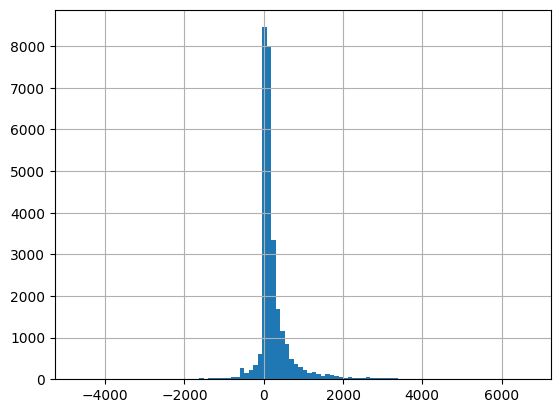

In [33]:
df['avg_item_profit'].hist(bins=100);

In [34]:
sign = (df['avg_item_profit'] > 0).astype(int)*2-1
df['avg_item_profit_log'] = (sign * np.log1p(np.abs(df['avg_item_profit'])))

In [35]:
df = df.drop('avg_item_profit', axis=1)

<h3>Normalize data</h3>

In [36]:
from sklearn import preprocessing

In [37]:
# define scaler
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df)

<h3>K-means</h3>

In [38]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS

In [39]:
from scipy.spatial.distance import cdist

In [126]:
%%time
# k means determine k
distortions = []
K_range = range(1,12)
for k in K_range:
    kmeanModel = KMeans(n_clusters=k, max_iter=1500, n_init=40, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    print('{} / {}'.format(k,K_range[-1]))

1 / 11
2 / 11
3 / 11
4 / 11
5 / 11
6 / 11
7 / 11
8 / 11
9 / 11
10 / 11
11 / 11
CPU times: user 59.9 s, sys: 9.18 s, total: 1min 9s
Wall time: 10 s


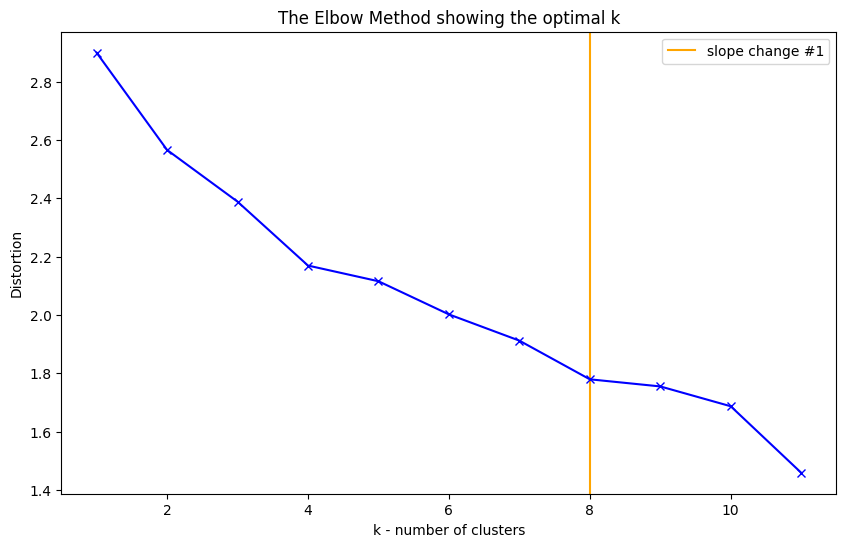

In [127]:
# Plot the elbow
plt.figure(figsize=(10,6))
#plt.axvline(6, 0, 1, label='slope change #1', color='red')
plt.axvline(8, 0, 1, label='slope change #1', color='orange')
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

<h3>Visualize</h3>

In [128]:
from sklearn.decomposition import PCA, TruncatedSVD

In [129]:
Y_pca = PCA(n_components=2).fit_transform(X);
Y_svd = TruncatedSVD(n_components=2).fit_transform(X);

In [131]:
K = 8
kmeanModel = KMeans(n_clusters=K, max_iter=1500, n_init=100, random_state=42).fit(X)

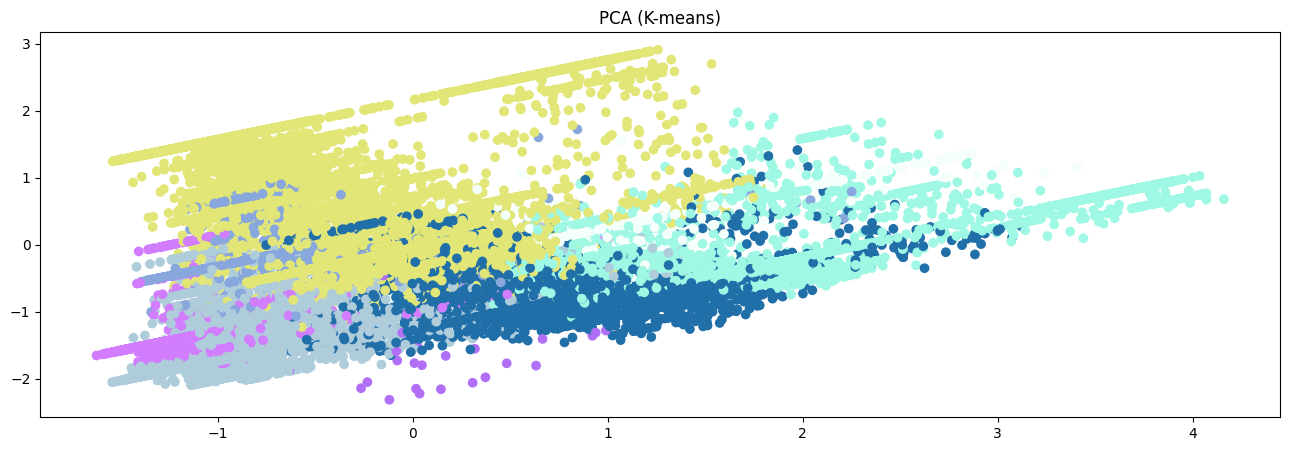

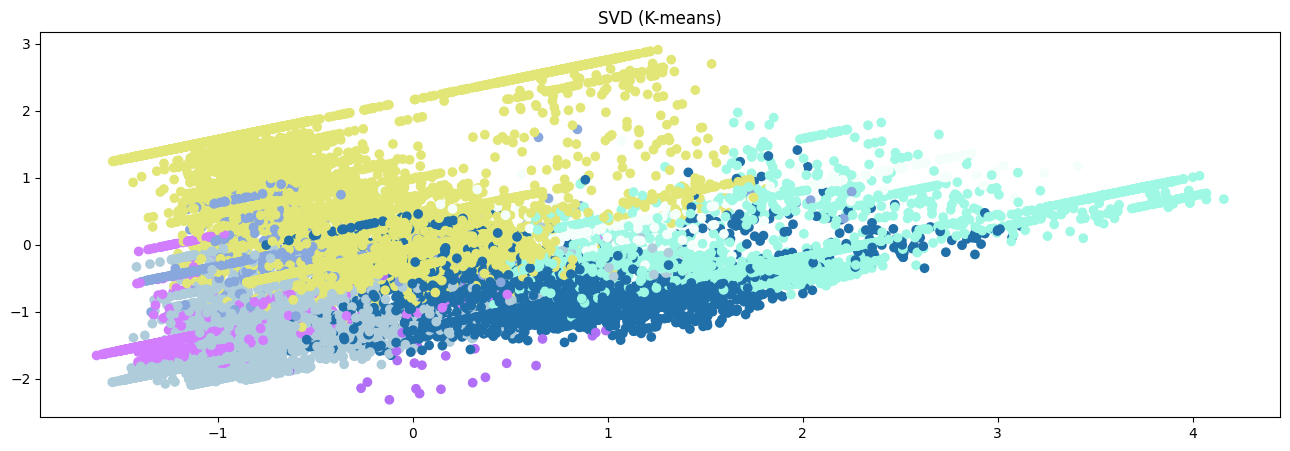

In [132]:
np.random.seed(21)
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16,5)); plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);

In [133]:
labels, counts = np.unique(kmeanModel.labels_, return_counts=True)

In [134]:
cluster_sizes = pd.Series(data=counts, index=labels).sort_index(ascending=True)

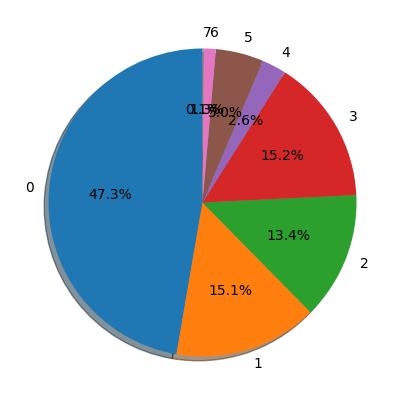

In [135]:
plt.figure(figsize=(16,5))
plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%', shadow=True, startangle=90);

In [51]:
summary_stat = copy.deepcopy(df)
summary_stat['cluster'] = kmeanModel.labels_

In [52]:
stats = summary_stat.groupby('cluster').mean()#.T.plot.bar();
stats

,related products,office goods,breastfeeding products,"textile, knitwear",footwear,toys,women things,goods for pets,cosmetics and hygiene,diapers,avg_delivered,avg_item_profit_log
cluster,,,,,,,,,,,,
0,0.000231,0.001483,0.795125,0.030135,0.004794,0.036987,0.000204,0.000476,0.023643,0.058240,0.955671,4.235417
1,0.002945,0.047935,0.013473,0.014508,0.005129,0.552471,0.000159,0.001150,0.011106,0.027573,0.939717,4.451271
2,0.000000,0.003749,0.001626,0.040800,0.898595,0.028813,0.000000,0.000351,0.001333,0.012837,0.942199,5.568925
3,0.000695,0.004134,0.013434,0.850557,0.015783,0.045477,0.000303,0.000712,0.010472,0.026333,0.927613,5.049195
4,0.000023,0.002451,0.014724,0.008880,0.003066,0.020041,0.000000,0.000984,0.019691,0.858144,0.929236,2.123977
5,0.000523,0.005858,0.063725,0.037043,0.006125,0.041329,0.000938,0.002693,0.648141,0.129028,0.924189,3.682203
6,0.000000,0.001157,0.030919,0.055415,0.043311,0.037525,0.580485,0.012500,0.141407,0.054539,0.941106,4.627883
7,0.000000,0.002517,0.002948,0.014237,0.004345,0.019478,0.000444,0.906416,0.018230,0.019978,0.928918,1.984514


In [53]:
pd.DataFrame(pd.Series(kmeanModel.labels_, df.index, name='k_means')).to_parquet('../data/sas/mart/kmeans.parquet')

<h3>DBSCAN</h3>

In [54]:
import math

In [64]:
%%time
X_sample = pd.DataFrame(X).sample(frac=1.0, random_state=42).values
eps, cluster_counts = [], []
for i in range(0,10):
    eps_p = 1.5 + 0.1*i
    dbscan = DBSCAN(eps=eps_p, algorithm='kd_tree', n_jobs=-1).fit(X_sample)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    eps.append(eps_p); cluster_counts.append(n_clusters_)
    print('{} / {}'.format(i+1, 10))

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
10 / 9
CPU times: user 4min 59s, sys: 2.87 s, total: 5min 1s
Wall time: 46.8 s


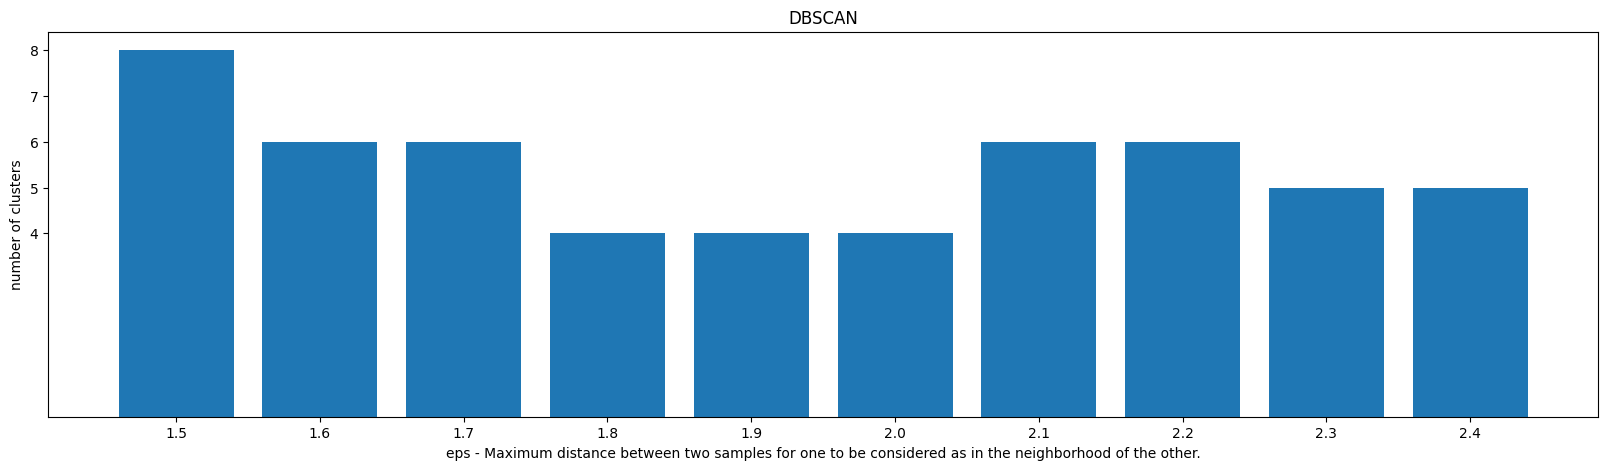

In [65]:
plt.figure(figsize=(20,5));
plt.yticks(range(min(cluster_counts), math.ceil(max(cluster_counts))+1));
plt.bar(np.round(np.array(eps), 2).astype(str), cluster_counts)
plt.xlabel('eps - Maximum distance between two samples for one to be considered as in the neighborhood of the other.')
plt.ylabel('number of clusters')
plt.title('DBSCAN');

<h3>T-SNE</h3>

In [66]:
from sklearn.manifold import TSNE

In [76]:
x_sample = np.random.choice(len(X), size=len(X), replace=False)

In [77]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(X[x_sample])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 28241 samples in 0.006s...
[t-SNE] Computed neighbors for 28241 samples in 5.474s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28241
[t-SNE] Computed conditional probabilities for sample 2000 / 28241
[t-SNE] Computed conditional probabilities for sample 3000 / 28241
[t-SNE] Computed conditional probabilities for sample 4000 / 28241
[t-SNE] Computed conditional probabilities for sample 5000 / 28241
[t-SNE] Computed conditional probabilities for sample 6000 / 28241
[t-SNE] Computed conditional probabilities for sample 7000 / 28241
[t-SNE] Computed conditional probabilities for sample 8000 / 28241
[t-SNE] Computed conditional probabilities for sample 9000 / 28241
[t-SNE] Computed conditional probabilities for sample 10000 / 28241
[t-SNE] Computed conditional probabilities for sample 11000 / 28241
[t-SNE] Computed conditional probabilities for sample 12000 / 28241
[t-SNE] Computed conditional probabilities for sa

In [78]:
sne_labels = kmeanModel.predict(X)[x_sample]

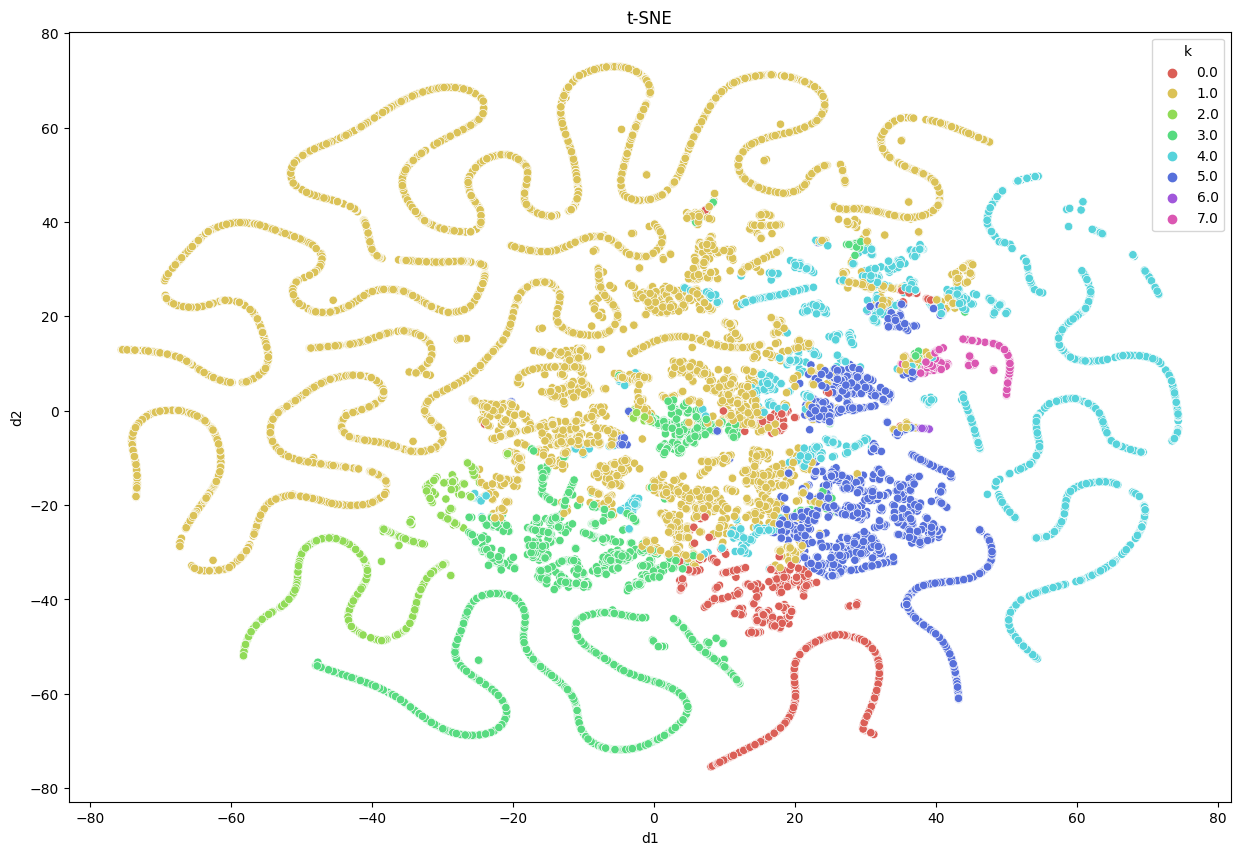

In [80]:
tSNE = pd.DataFrame(np.vstack((tsne_results.T, sne_labels)).T, columns=['d1', 'd2', 'k'])

plt.figure(figsize=(15,10)); plt.title('t-SNE')
sns.scatterplot(x='d1', y='d2', hue='k', data=tSNE, legend='full', alpha=1.,
                palette=sns.color_palette('hls', kmeanModel.n_clusters));

<h3>RFM</h3>

In [81]:
#Recency — number of days since the last purchase
#Frequency — number of transactions made over a given period
#Monetary — amount spent over a given period of time

In [85]:
#ds = pd.read_parquet('./data/clean/all_positions.parquet')
ds = pd.read_csv('../data/sas/all_positions.csv')

In [86]:
ds = ds.rename(columns={'Телефон_new': 'phone'})

In [89]:
ds['ДатаДоставки'] = pd.to_datetime(ds['ДатаДоставки'], format='%Y-%m-%d')

In [90]:
ds = ds.sort_values(by='ДатаДоставки', ascending=False).groupby('phone').head(1)

In [91]:
most_recent = ds['ДатаДоставки'].max()

In [92]:
# Recency
ds['Recency'] = most_recent - ds['ДатаДоставки']

In [93]:
Recency = ds.set_index('phone')['Recency'].dropna()
Recency = Recency[Recency.index.isin(data.index)]
Recency

phone
55575653-55554854545478    0 days
55574856-57495248514975    2 days
55575351-48524848505275    3 days
55575054-52545556555474    3 days
55574850-56555356555770    9 days
                            ...  
55575054-51495751515071   87 days
55574851-49574948495171   87 days
55575453-52515448494978   87 days
55574954-51504848485777   87 days
55575450-57505048555771   88 days
Name: Recency, Length: 28834, dtype: timedelta64[ns]

In [94]:
recency = pd.DataFrame(Recency.dt.days)
frequency = data[['successful_orders_count']].rename(columns={'successful_orders_count': 'Frequency'})
monetary = data[['total_profit']].rename(columns={'total_profit': 'Monetary'})

In [95]:
assert recency.shape == frequency.shape == monetary.shape

In [96]:
RFM = pd.merge(pd.merge(recency, frequency, on='phone'), monetary, on='phone')

In [97]:
RFM

,Recency,Frequency,Monetary
phone,,,
55575653-55554854545478,0,1,2174.23
55574856-57495248514975,2,2,2934.00
55575351-48524848505275,3,3,1995.27
55575054-52545556555474,3,1,842.50
55574850-56555356555770,9,1,4764.37
...,...,...,...
55575054-51495751515071,87,1,1299.50
55574851-49574948495171,87,1,106.05
55575453-52515448494978,87,1,444.30


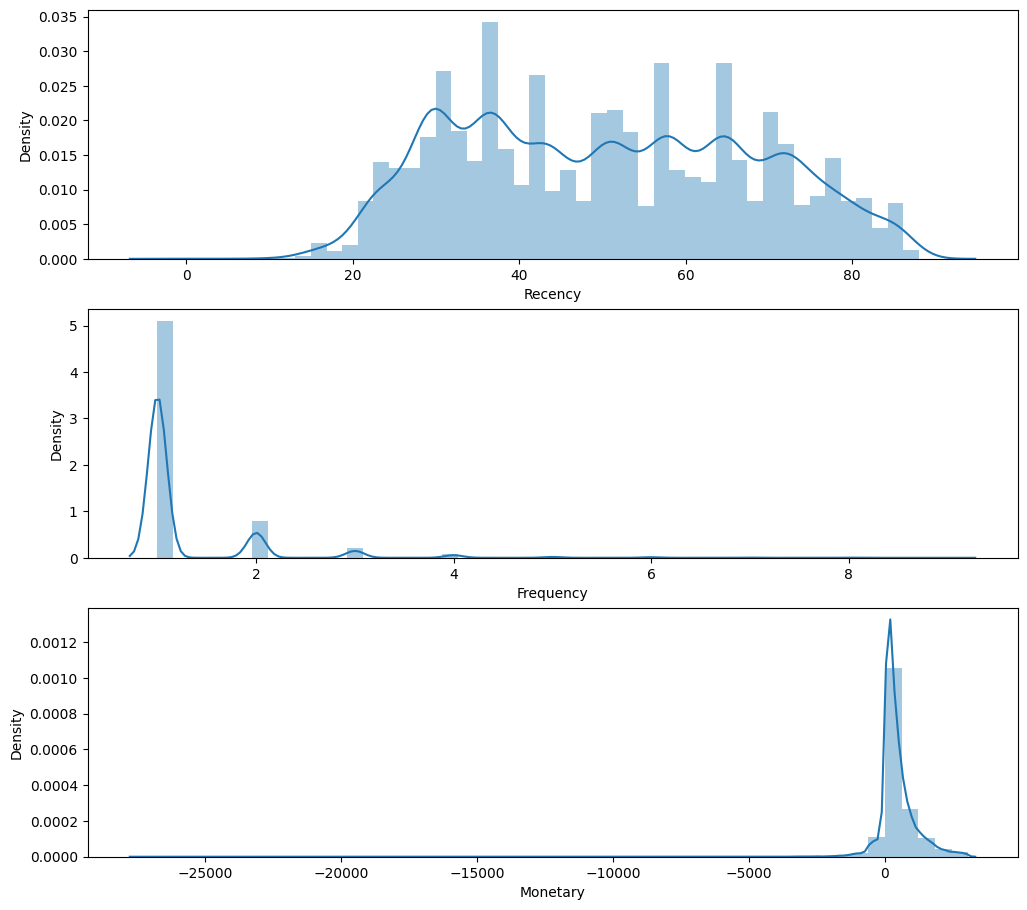

In [111]:
# Plot RFM distributions
plt.figure(figsize=(12,11))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RFM['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RFM['Frequency'][RFM['Frequency'] < RFM['Frequency'].quantile(0.999)])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RFM['Monetary'][RFM['Monetary'] < RFM['Monetary'].quantile(0.97)])
# Show the plot
plt.show()

In [112]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 4)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(RFM['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(RFM['Frequency'], q=20, labels=f_labels, duplicates='drop')
# Create new columns R and F 
RFM = RFM.assign(R = r_groups.values, F = f_groups.values)
RFM.head()

,Recency,Frequency,Monetary,R,F
phone,,,,,
55575653-55554854545478,0,1,2174.23,4,1
55574856-57495248514975,2,2,2934.00,4,1
55575351-48524848505275,3,3,1995.27,4,2
55575054-52545556555474,3,1,842.50,4,1
55574850-56555356555770,9,1,4764.37,4,1


In [113]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(RFM['Monetary'], q=4, labels=m_labels)
# Create new column M
RFM = RFM.assign(M = m_groups.values)

In [114]:
RFM

,Recency,Frequency,Monetary,R,F,M
phone,,,,,,
55575653-55554854545478,0,1,2174.23,4,1,4
55574856-57495248514975,2,2,2934.00,4,1,4
55575351-48524848505275,3,3,1995.27,4,2,4
55575054-52545556555474,3,1,842.50,4,1,4
55574850-56555356555770,9,1,4764.37,4,1,4
...,...,...,...,...,...,...
55575054-51495751515071,87,1,1299.50,1,1,4
55574851-49574948495171,87,1,106.05,1,1,1
55575453-52515448494978,87,1,444.30,1,1,3


In [115]:
%%time
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

RFM['RFM_Segment_Concat'] = RFM.apply(join_rfm, axis=1)
rfm = RFM
rfm.head()

CPU times: user 155 ms, sys: 3.23 ms, total: 159 ms
Wall time: 159 ms


,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat
phone,,,,,,,
55575653-55554854545478,0,1,2174.23,4,1,4,414
55574856-57495248514975,2,2,2934.00,4,1,4,414
55575351-48524848505275,3,3,1995.27,4,2,4,424
55575054-52545556555474,3,1,842.50,4,1,4,414
55574850-56555356555770,9,1,4764.37,4,1,4,414


In [116]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print('Number of unique segmens:', rfm_count_unique.sum())

Number of unique segmens: 48


<h3>Summing the score</h3>

In [117]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

phone
55575653-55554854545478     9
55574856-57495248514975     9
55575351-48524848505275    10
55575054-52545556555474     9
55574850-56555356555770     9
Name: RFM_Score, dtype: int64


In [118]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Sleeping' # Primising
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
phone,,,,,,,,,
55575653-55554854545478,0,1,2174.23,4,1,4,414,9,Can't Loose Them
55574856-57495248514975,2,2,2934.00,4,1,4,414,9,Can't Loose Them
55575351-48524848505275,3,3,1995.27,4,2,4,424,10,Can't Loose Them
55575054-52545556555474,3,1,842.50,4,1,4,414,9,Can't Loose Them
55574850-56555356555770,9,1,4764.37,4,1,4,414,9,Can't Loose Them


<h3>RFM results</h3>

In [120]:
import squarify

In [121]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg.loc[["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]])

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      30.6       2.5   1773.6  2734
Champions             36.1       1.4    987.8  3426
Loyal                 43.8       1.2    808.8  5151
Potential             49.6       1.1    479.0  7022
Sleeping              58.6       1.1    183.1  5319
Require Activation    74.7       1.0    -68.3  1685


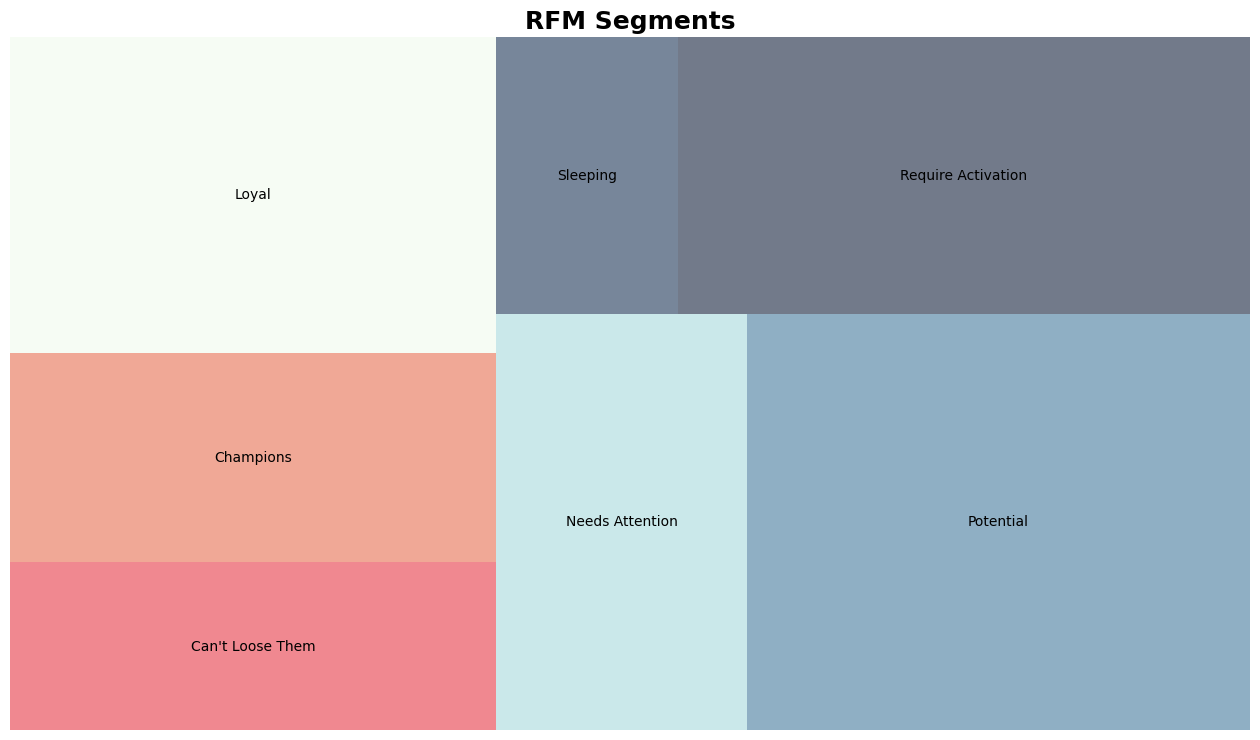

In [122]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Sleeping', 
                     'Require Activation'],
              color=['#e63946',
                     '#e76f51',
                     '#f1faee',
                     '#a8dadc',
                     '#457b9d',
                     '#1d3557',
                     '#14213d'],
              alpha=.6,)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<h3>Save RFM</h3>

In [123]:
from pathlib import Path

In [124]:
Path("../data/sas/rfm").mkdir(parents=True, exist_ok=True)

In [125]:
rfm.to_parquet('../data/sas/mart/rfm.parquet')